In [1]:
import numpy as np
import matplotlib.pyplot as plt

from latent_process import MaternProcess
from filtsmooth import QuadFormKalmanFilter
from data import Dataset

In [2]:
func = lambda grid : np.sin(2 * np.pi * grid)
dist = 'normal'
params = {"loc": 0, "scale": 0.5}
tmin, tmax = (0.5, 4.0)
num_data_pts = 80
dataset = Dataset(tmin=tmin, tmax=tmax, num_data_pts=num_data_pts, func=func, dist=dist, params=params)

obs_grid, obs = dataset.observations()

In [3]:
#---------------latent process------------------
n = 1 
p = 2 
magnitude, lengthscale = (3, 0.4)
mp = MaternProcess(n=n, p=p, magnitude=magnitude, lengthscale=lengthscale)

#--------------observation process---------------------
output_dim = 1 if len(obs.shape)==1 else obs.shape[-1] 
obs_noise = 1.7
H = np.concatenate([np.eye(n), np.zeros((n, n * p))], axis=1)
R = obs_noise * np.eye(output_dim)

#-------------defining M and v------------------------
M = H.T @ np.linalg.inv(R) @ H
def v(y):
    assert y.T.shape == (len(R), 1)
    return H.T @ np.linalg.inv(R) @ y.T

#------------filtering & smoothing---------------------
subdiv = 1
filter = QuadFormKalmanFilter(obs_grid=obs_grid, obs=obs, latent_process=mp, subdiv=subdiv, M=M, v=v)
m_filt, P_filt, m, P = filter.filtsmooth()

m_filt_hat = m_filt[:, 0].flatten()
m_smooth_hat = m[:, 0].flatten()

Smoothing: 100%|██████████| 80/80 [00:00<00:00, 5452.90it/s]


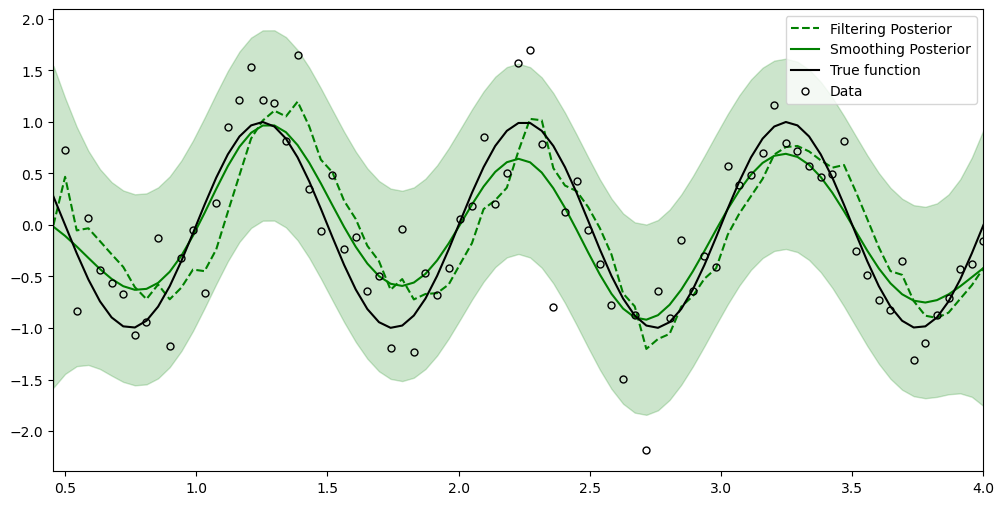

In [6]:
plt.figure(figsize=(12,6))

plt.plot(filter.filter_grid, m_filt_hat, '--', color = 'green', label='Filtering Posterior')
plt.plot(filter.filter_grid, m_smooth_hat, '-', color='green', label = 'Smoothing Posterior')
plt.fill_between(filter.filter_grid, m_smooth_hat - 2 * np.sqrt(P[:, 0, 0]), m_smooth_hat + 2 * np.sqrt(P[:, 0, 0]), alpha=0.2, color='green')
plt.plot(filter.filter_grid, func(filter.filter_grid), color='black', label='True function')
plt.plot(obs_grid, obs, 'o', markersize=5, color='black', fillstyle = 'none', label='Data')
plt.legend()
plt.xlim(filter.filter_grid[0], filter.filter_grid[-1]);